# Short Read Variant Calling With Giraffe & DeepVariant

The tutorial demonstrates variant calling using the Human Pangenome Reference Consortium's (HPRC) year 1 Minigraph/CACTUS pangenome with the Giraffe/DeepVariant pipeline for calling germline small variants. 

For this demonstration, we will work with a region of chromosome 1 containing, among others, the RHCE gene which is a a challenging medically-relevant gene. "Challenging medically-relevant genes" are difficult to assess with short-read sequencing but are part of a recent benchmark truthset ([CRMG v1.0](https://www.nature.com/articles/s41587-021-01158-1)). The genomic interval extracted was `chr1:25053647-25685365` ([see in the UCSC Genome Browser](https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&position=chr1%3A25053647%2D25685365)). 
The reads and pangenome in this workspace correspond to this slice of the genome.

An Illumina dataset (produced by Google and made publicly available) with 30X coverage of HG002 has been sliced on the relevant region (as explained above). 

This workspace uses one of the HPRC's year 1 pangenomes created with the [Minigraph/CACTUS pipeline](https://github.com/ComparativeGenomicsToolkit/cactus/blob/master/doc/pangenome.md). For the Giraffe/DeepVariant pipeline, it is now recommended to use haplotype sampling on the full GRCh38-based graph (v1.1). Information about the HPRC's pangenome releases can be found in the HPRC's [pangenome resources GitHub repo](https://github.com/human-pangenomics/hpp_pangenome_resources).
For this demonstration, we extracted the sub-graph of the chr1 region.

Load some packages that we will use in this notebook.

In [2]:
import pandas as pd         ## for holding workspace table data in dataframes
import os                   ## for reading in bucket location
from IPython.display import Image, display ## for showing images in the notebook
import cyvcf2                  ## to read VCF files

# Quick look at the data

First let's count the nodes, edges, and the total sequence in the pangenome graph.

In [3]:
!vg stats -zl rhce_data/hprc-v1.0-mc-grch38.chr1_25053647_25685365.gbz

nodes	17966
edges	24831
length	714761


Here we used the `stats` subcommand from vg, asking to print the graph's size (`-z`) and total length (`-l`).

Next we count the number of paths (haplotypes) in the pangenome, and print the length of a couple.

In [4]:
!vg paths -Lx rhce_data/hprc-v1.0-mc-grch38.chr1_25053647_25685365.gbz | wc -l

91


The `paths` subcommand is all about paths. Here we count them by listing them (`-L`) and counting the number of lines in the output with `wc`.

In [5]:
!vg paths -Ex rhce_data/hprc-v1.0-mc-grch38.chr1_25053647_25685365.gbz | head

HG00621.1.JAHBCD010000037.1[0-35449780][26254622]#0#0#0	633212
HG02559.2.JAGYVJ010000027.1[23420692]#0#0#0	563038
HG01928.1.JAGYVQ010000014.1[26259413]#0#0#0	633168
HG02559.1.JAGYVK010000054.1[0-36072197][26250913]#0#0#0	632618
HG02622.2.JAHAON010000073.1[15466790]#0#0#0	633359
HG01358.2.JAGYZA010000032.1[9571895-44971586][8500121]#0#0#0	633309
HG01361.2.JAGYYW010000019.1[14008927]#0#0#0	633174
HG00621.2.JAHBCC010000004.1[15399920]#0#0#0	633112
HG02818.1.JAHEOS010000052.1[7175661-60494670][8409652]#0#0#0	633069
HG02109.1.JAHEPG010000017.1[15235623]#0#0#0	632968


The `-E` option lists all the paths and their length. They are about 600 Kbp long.

Finally, let's have a quick look at two sequencing reads in one of the FASTQ files.

In [6]:
!zcat rhce_data/HG002.chr1_25053647_25685365.R1.fastq.gz | head -8

@A00744:46:HV3C3DSXX:2:1101:10384:19163
AACCACTCTTTTGAATAGCAGAGAAAACCTCAGACTGCCATATCTGGGAGAGATTTTAGCAACATTATGTTTTCATTGTATCTCTTTTTACAGCTACCTCCCATTTCCCTTCTATTTAAAGCTAGTAACACAGTTTTCTTTTAAATTCATT
+
FF:FFFFF:F,F:F:FFF::FFFFFFF,,F,F:F::FF::F,,,FFF,FFFFFF,FFF,F:,F::,,FF:::,F:FF:FFF,FFFF,,FFFF:FFF,FF::FFF,,FFFF,FFFF:F,FF,F,F:F,F,FFFF,,F,,FFFFFFFF:FFFF
@A00744:46:HV3C3DSXX:2:1101:10520:36714
CAACTTCTTGAGTTAATCTCTCCATGTTGGAAAGCTTCCCTTGCTGGTTTCCCCATATGCTTCCAGCTTCAAGTCCTTTTTGGCTTCAAAACCACATGCCTGTGGTTCCAGCTACTGAGGAGGCTGAGGTGGGAGGATCGCTTGAGTCCAG
+
FFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFF

gzip: stdout: Broken pipe


# Mapping reads to the pangenome with vg giraffe

Here we show a **minimal command** to map the sequencing reads (gzipped FASTQ files), to the pangenome (GBZ file).

In [7]:
!vg giraffe -Z rhce_data/hprc-v1.0-mc-grch38.chr1_25053647_25685365.gbz -t 4 -f rhce_data/HG002.chr1_25053647_25685365.R1.fastq.gz -f rhce_data/HG002.chr1_25053647_25685365.R2.fastq.gz -o gaf > test.gaf

[IndexRegistry]: Constructing distance index for Giraffe.
[IndexRegistry]: Constructing minimizer index.


The pangenome in GBZ format is given with `-Z` while the reads are given with `-f`.
If needed, giraffe will make the necessary *distance* and *minimizer* indexes. 

**Note**: if indexes are available, for example for public pangenomes, it is better to use them rather than recreate them because it can take some time and a fair amount of memory to build on large pangenomes.

The output was redirected to the `test.gaf` file which represents the mapped reads in the [GAF format](https://github.com/lh3/gfatools/blob/master/doc/rGFA.md#the-graph-alignment-format-gaf). Let's have a look at the first read.

In [8]:
!head -1 test.gaf

A00744:46:HV3C3DSXX:2:1101:10520:36714	151	0	151	+	<3775480<3775481<3775483<3775484<3775486	443	219	370	151	151	60	AS:i:161	bq:Z:FFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFF	cs:Z::151	dv:f:0	fn:Z:A00744:46:HV3C3DSXX:2:1101:10520:36714	pd:b:1


## Mapping to the pangenome and making a BAM relative to a reference

If you are just interested in the read alignment relative to a reference, i.e. the reads aligned to the pangenome and then projected(/surjected) to the reference path, you might want to **output a BAM directly**. 

In [9]:
!echo GRCh38.chr1 > ref.paths.txt
!vg giraffe -Z rhce_data/hprc-v1.0-mc-grch38.chr1_25053647_25685365.gbz -t 4 -f rhce_data/HG002.chr1_25053647_25685365.R1.fastq.gz -f rhce_data/HG002.chr1_25053647_25685365.R2.fastq.gz -o BAM --ref-paths ref.paths.txt > test.bam

Guessing that rhce_data/hprc-v1.0-mc-grch38.chr1_25053647_25685365.dist is Giraffe Distance Index
Guessing that rhce_data/hprc-v1.0-mc-grch38.chr1_25053647_25685365.min is Minimizers


With `-o BAM` we asked for a BAM output, and with `--ref-paths` we specified a file that contains a list of paths to use as reference for the projection/surjection. We created this file so that it contains `GRCh38.chr1`.

Check a few aligned reads in the BAM:

In [10]:
!samtools view test.bam | head -3

A00744:46:HV3C3DSXX:2:1101:10520:36714	83	GRCh38.chr1	478792	60	151M	=	478706	-66	CTGGACTCAAGCGATCCTCCCACCTCAGCCTCCTCAGTAGCTGGAACCACAGGCATGTGGTTTTGAAGCCAAAAAGGACTTGAAGCTGGAAGCATATGGGGAAACCAGCAAGGGAAGCTTTCCAACATGGAGAGATTAACTCAAGAAGTTG	FFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFF	AS:i:156
A00744:46:HV3C3DSXX:2:1101:10520:36714	163	GRCh38.chr1	478706	60	12M1D139M	=	478792	66	GATTTTTTTTTTCAGACAGGGTCTCACTCTGTTGCCCAGGCTGGAGTGCAGTGGTGCGATCTCGGCTCACTGCAGCCTCCACCTCCTGGACTCAAGCGATCCTCCCACCTCAGCCTCCTCAGTAGCTGGAACCACAGGCATGTGGTTTTGA	FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,FFFFFFFFFF	AS:i:155
A00744:46:HV3C3DSXX:2:1101:10628:23782	83	GRCh38.chr1	69215	60	151M	=	69155	-91	CTCTGCCACATGGTCACCTGCATTCCACAGTGAAGTACTCCATATCTACCATTGTTCAGTGTCATGCCAGGAGCTGCTTTTGCAATGGAGAGTCCTCTCTGCCAGAGAGGCCTGGCCTTGATACA

# Run the vg Giraffe-DeepVariant workflow

The sections above are useful to get a feel for the commands and imagine how to modify an existing pipeline to use a pangenome as reference. 

In practice, more steps are involved to achieve the best performance both in term of accuracy and compute. We've implemented a **workflow to uses Giraffe and DeepVariant to call small variants** in two languages:

1. A **WDL** workflow that is best suited for cloud environments like the [AnVIL platform](https://anvilproject.org/).
2. A **Snakemake** workflow that can run locally or on a HPC more easily.

This workflow integrates several steps to improve scale and accuracy, including:
- Haplotype-sampling of the pangenome based on the kmer distribution in the reads
- Read realignment with bamleftalign and ABRA2 to improve indel accuracy
- Sequence renameing (`GRCh38.chr1` to `chr1`) in the BAM and VCF.
- GPU usage for DeepVariant

First, let's get the Snakemake workflow from https://github.com/vgteam/vg_snakemake

In [11]:
!git clone -b hapsampdv https://github.com/vgteam/vg_snakemake.git

Cloning into 'vg_snakemake'...
remote: Enumerating objects: 328, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 328 (delta 19), reused 31 (delta 11), pack-reused 282
Receiving objects: 100% (328/328), 54.29 MiB | 11.40 MiB/s, done.
Resolving deltas: 100% (141/141), done.


Then we can run it.

If you are using the docker image from Zenodo (from `curl XXX | docker load`) you can use the Singularity images that were already cached:

In [ ]:
!snakemake --singularity-prefix /singularity_cache --use-singularity --snakefile vg_snakemake/workflow/Snakefile --configfile smk.config.rhce.yaml --cores 8 all

Otherwise, if you use the "lightweight" docker image, there is no Singularity cache to use, you will download the images on the fly (which can take a few minutes):

In [14]:
!snakemake --use-singularity --snakefile vg_snakemake/workflow/Snakefile --configfile smk.config.rhce.yaml --cores 8 all

Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 8
Rules claiming more threads will be scaled down.
Job stats:
job                        count
-----------------------  -------
all                            1
coverage_mosdepth              1
dv_call_variants               1
dv_make_examples               1
extract_unmapped_reads         1
gaf_to_sorted_gam              1
index_bam                      1
index_distance                 1
index_fasta                    1
index_haplotype_kmers          1
index_minimizer                1
index_r_fullpg                 1
map_short_reads_giraffe        1
pack                           1
sample_haplotypes              1
surject_reads                  1
sv_call_manta                  1
vgcall                         1
total                         18

Select jobs to execute...

[Mon Apr 15 14:07:18 2024]
rule index_r_fullpg:
    input: rhce_data/hprc-v1.0-mc-grch38.chr1_25053647_25685365.gbz
    output: results/pg/hprc-v1.0-mc-gr

**Note**: Running the pipeline produces a lot of output which might be easier to appreciate in a Terminal. Feel free to start a terminal and run the command there.

**Note**: There might be an error about "loop devices" (`# FATAL:   container creation failed: mount /proc/self/fd/4->/var/lib/singularity/mnt/session/rootfs error: while mounting image /proc/self/fd/4: failed to find loop device: could not attach image file to loop device: no loop devices available`). If that's the case, try to re-run the command until it finishes.

Let's break down the *snakemake* command:
- `--singularity-prefix /singularity_cache --use-singularity` to use containerized tools with Singularity and to look for cached tools in a specific folder (prepared for the workshop). Again this is used if using the JupyterHub with the large files included. Otherwise, if omitted, the tools will be download when needed.
- `--snakefile vg_snakemake/workflow/Snakefile` specifies where to find the workflow definition
- `--configfile smk.config.rhce.yaml` points to the configuration files with info about file paths and parameters. Have a look at it.
- `--cores 8` sets the maximum number of cores used by the workflow.
- `all` the *rule* to run. Here "all" means to make all the outputs.

Have a look at the files in the `results` folder.

More specifically, let's have a quick look at a couple of the variants called by Giraffe-DeepVariant. They are in the `HG002.hprc-v1.0-mc-grch38.chr1_25053647_25685365.surj.snv_indels.vcf.gz` file in the `results/HG002` directory.

In [15]:
!zcat results/HG002/HG002.hprc-v1.0-mc-grch38.chr1_25053647_25685365.surj.snv_indels.vcf.gz | head -20

##fileformat=VCFv4.2
##FILTER=<ID=PASS,Description="All filters passed">
##FILTER=<ID=RefCall,Description="Genotyping model thinks this site is reference.">
##FILTER=<ID=LowQual,Description="Confidence in this variant being real is below calling threshold.">
##FILTER=<ID=NoCall,Description="Site has depth=0 resulting in no call.">
##INFO=<ID=END,Number=1,Type=Integer,Description="End position (for use with symbolic alleles)">
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Conditional genotype quality">
##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Read depth">
##FORMAT=<ID=MIN_DP,Number=1,Type=Integer,Description="Minimum DP observed within the GVCF block.">
##FORMAT=<ID=AD,Number=R,Type=Integer,Description="Read depth for each allele">
##FORMAT=<ID=VAF,Number=A,Type=Float,Description="Variant allele fractions.">
##FORMAT=<ID=PL,Number=G,Type=Integer,Description="Phred-scaled genotype likelihoods rounded to the close

# Visualize reads mapped across a variant site

We want to visualize the read alignments on the pangenome at the location of a small variant that was called by the Giraffe-DeepVariant workflow.

To do that, we will need three files:

1. the pangenome index with the information about the nodes/edges/sequences (GBZ file)
1. the VCF file with the small variant calls (one of the output of the workflow).
1. the GAM file with the reads aligned to pangenome, sorted and indexed (another output of the workflow).


In [16]:
PAN_IDX = 'rhce_data/hprc-v1.0-mc-grch38.chr1_25053647_25685365.gbz'
SMALL_VCF = 'results/HG002/HG002.hprc-v1.0-mc-grch38.chr1_25053647_25685365.surj.snv_indels.vcf.gz'
SORTED_GAM = 'results/HG002/HG002.hprc-v1.0-mc-grch38.chr1_25053647_25685365.sorted.gam'

We will be looking at variants called by the Giraffe/DeepVariant pipeline **in an exon of RHCE**.
For example, take a look at this region in the UCSC Genome Browser: [chr1:25408683-25408869](https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&position=chr1%3A25408683%2D25408869).

**Note**: the pangenome that we use for this demo is a slice of the genome, starting at 25053647, so we have to remove this offset to get the appropriate coordinates in this slice.

In [17]:
coord_wg  = [25408683, 25408869] ## coordinate relative to the whole genome
offset    = 25053647
coord_sub = [pos - offset for pos in coord_wg] ## coordinate relative to our slice

region_subset = 'chr1:{}-{}'.format(coord_sub[0], coord_sub[1])
print("In this slice of the pangenome, the region of interest is at: " + region_subset)

In this slice of the pangenome, the region of interest is at: chr1:355036-355222


## Find variant in the VCF

**Open the VCF with the cyvcf2 package.**

In [18]:
vcf_reader = cyvcf2.VCF(SMALL_VCF)

**Loop over the variant in the region of interest.
If a variant is homozygous for the alternate allele, we record its position and stop.**

In [19]:
var_pos = ''
for record in vcf_reader('chr1:{}-{}'.format(coord_sub[0], coord_sub[1])):
    if record.genotypes[0][0] == 1 and record.genotypes[0][1] == 1:
        print(record)
        var_pos = record.start
        break
print('There is a variant at position {}'.format(var_pos))

chr1	355064	.	G	A	17.5	PASS	.	GT:GQ:DP:AD:VAF:PL	1/1:14:31:0,31:1:17,16,0

There is a variant at position 355063


**Note:** This is the variant that we will look for in the pangenome and in the aligned reads.

## Extract & visualize graph around the variant

To zoom in to the region around the variant site, we will extract the subgraph around this region.
In practice, we use a subcommand of `vg` to locate the subset of the pangenome of interest, and extract nodes and edges close to it.
The most common type query is to look for a sub-region of the reference path (GRCh38 here), and then add the additional nodes/edges touching it. 

**Extract the graph region with `vg find`**
* `-p` extracts a subgraph touching a region defined as *PATH:START-END*.
Here we defined it in the *region* object above.
* `-c` defines the **c**ontext that the subgraph should include around the queried path. Here we extend by 2 nodes.

In [20]:
region = 'GRCh38.chr1:{}-{}'.format(var_pos, var_pos)
!vg find -x {PAN_IDX} -p {region} -c 2 > graph.vg

The subgraph was written in a VG file. This file can be converted to different formats using `vg view`. 
For example, you could convert it to GFA and visualize it with [Bandage](https://rrwick.github.io/Bandage/).
We can also convert it to [DOT](https://en.wikipedia.org/wiki/DOT_%28graph_description_language%29) (a graph description language) and create an image with the `dot` command.

**Now view the graph region**
- `vg view` with the `-d` will convert a graph into a **D**OT file.
- `-p` shows the **p**ath(s), here the *GRCh38.chr6* reference path.
- `-C` **c**olors the non-reference nodes in red.
- `dot` converts the DOT output into a PNG image

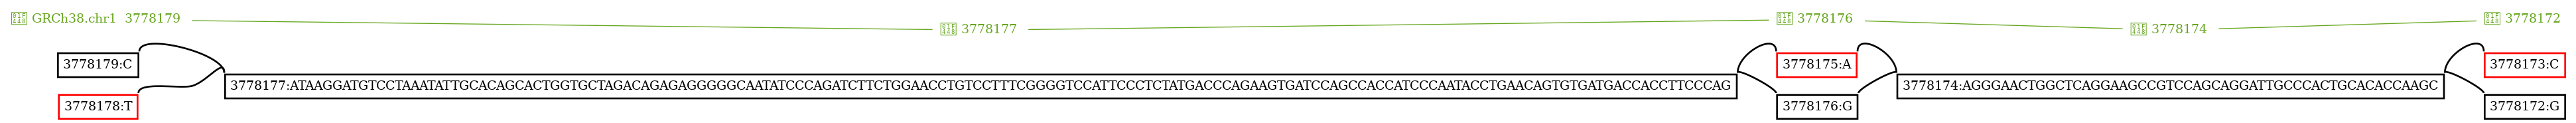

In [21]:
!vg view -dpC graph.vg | dot -Tpng -o graph.png
display(Image(filename="graph.png"))

*It looks like our G/A SNV is in the pangenome. Node 3778176 represent the reference *G* allele.*

## Extract reads around the variant

**Use vg find to extract all reads touching the subgraph that we just looked at above.**
- `-l` specifies the (sorted and indexed) reads to query.
- `-A` specifies to query the subgraph *graph.vg* to query.
- `-a` count the number of line in the JSON representation of the reads.

In [22]:
!vg find -A graph.vg -l {SORTED_GAM} > reads.gam
!vg view -a reads.gam | wc -l

74


That's a lot of reads! If we add all of them in the image, it will be hard to see what is going on.

**Let's downsample them to make less busy images.**
* `-d 0.XX` downsample to XX% of the reads

In [23]:
!vg find -A graph.vg -l {SORTED_GAM} | vg filter -d 0.1 - > reads.10pct.gam
!vg view -a reads.10pct.gam | wc -l

11


## Visualize graph and reads with vg

We use a similar `vg view` command as above. The only difference is that we specify the reads with `-A`, and use `-m` to disregard mapping to nodes absent from the subgraph.

In [24]:
!vg view -A reads.10pct.gam -dpmC graph.vg | dot -Tpng -o graph.reads.png

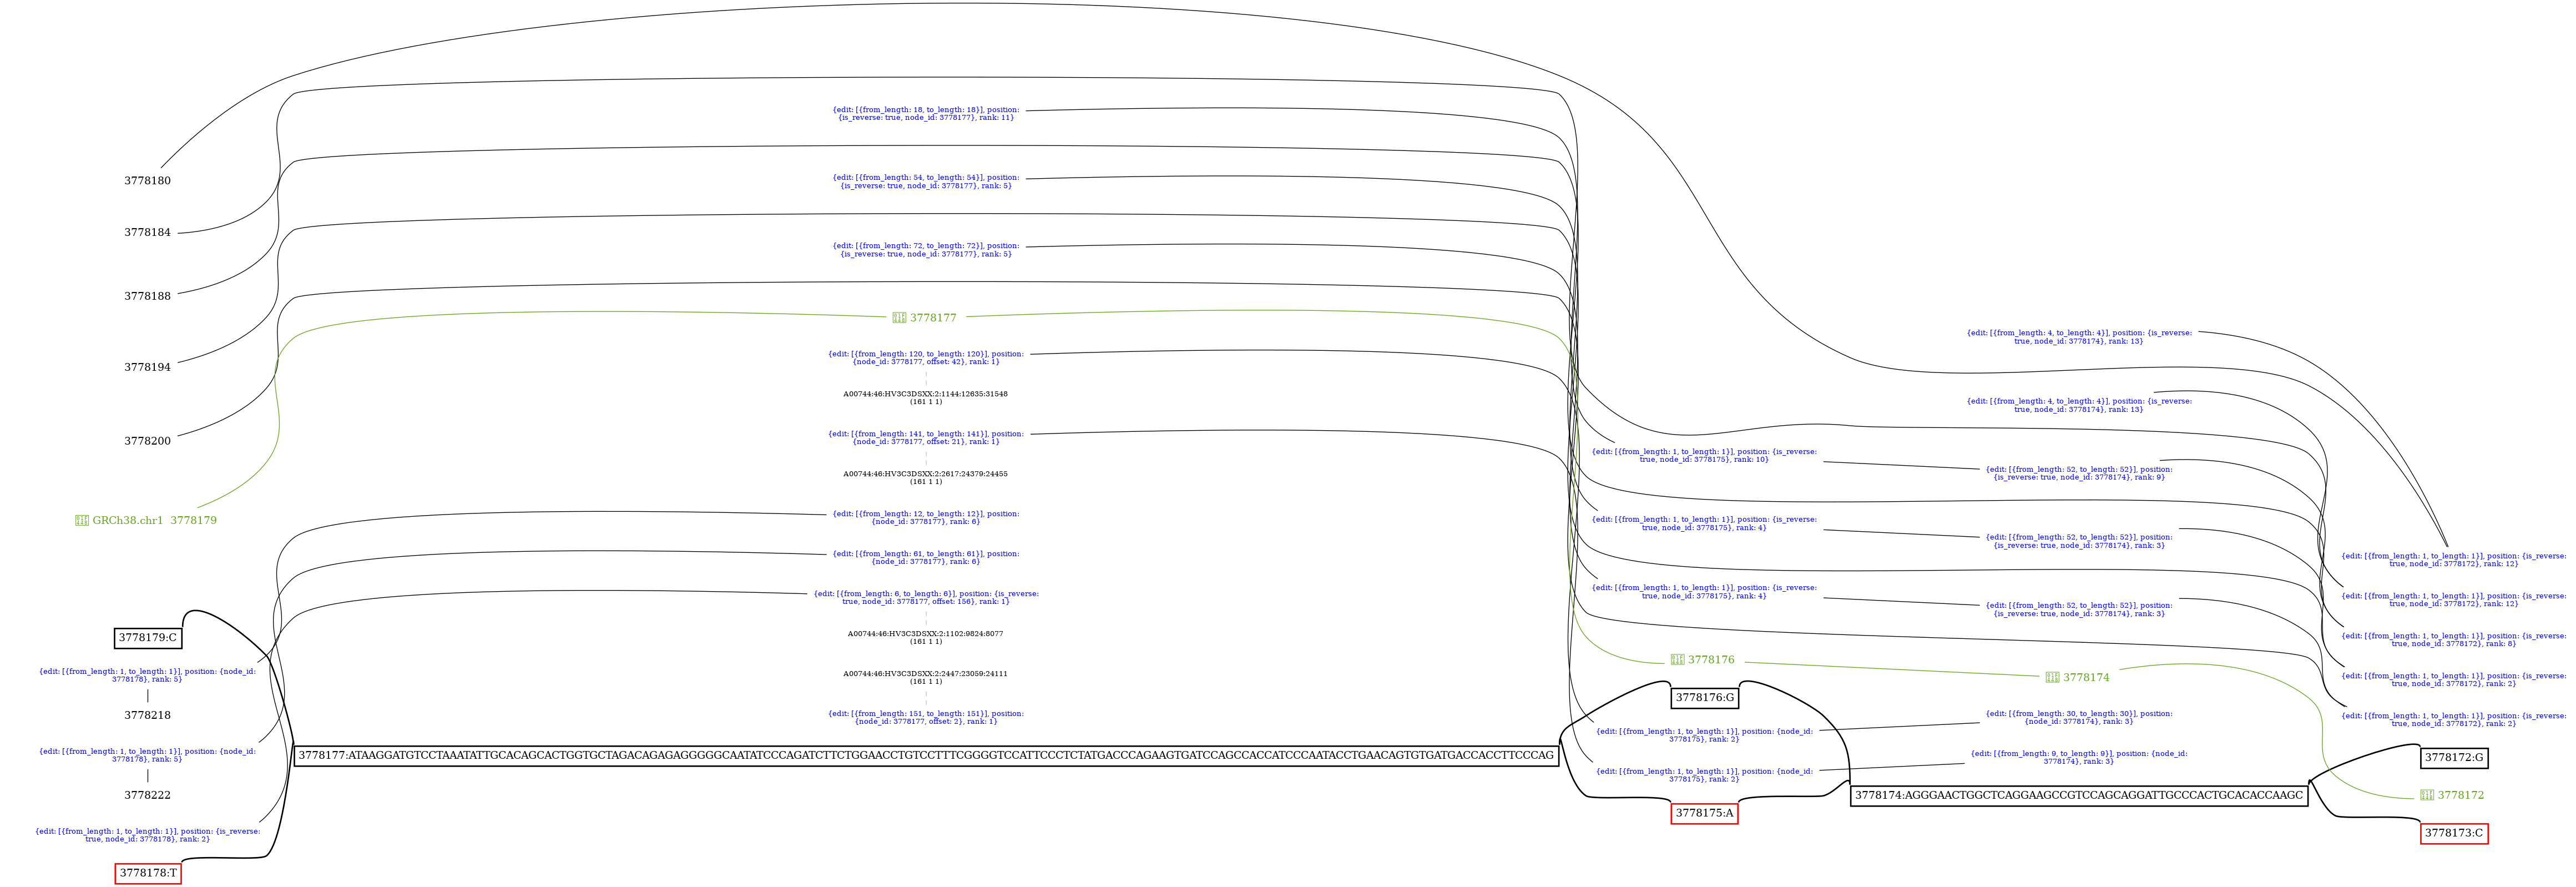

In [25]:
display(Image(filename="graph.reads.png"))

*We see that all reads align through the non-reference node. This is consistent with the SNV being homozygous.*

### Optional. Try the sequenceTubeMap

This approach can be useful to look at a small subgraph or automate image creation. 
For other use cases, we tend to use the interactive (and better-looking) [SequenceTubeMap](https://github.com/vgteam/sequenceTubeMap). 

To visualize and navigate across a large pangenome and full read dataset, you would need to start a sequenceTubeMap server yourself. In the context of this workshop, **we've prepared a sequenceTubeMap server with this pangenome and reads already loaded**. 

Access it through the landing page then use the *Region* field to navigate to the correct position in the pangenome.

To manipulate the tubemap, you can:
- Hold-click to move horizontally
- Scroll to zoom in/out
- Change some visualization settings in the configuration panel below the graph.

![](tubemap.screenshot.png)

## Where would one read map to the linear reference genome?

We've just saw that the variant site was present in the pangenome and that reads align through it. 
Because the reads are mapped there, once they were projected to GRCh38 and fed to DeepVariant, the appropriate homozygous SNV was called.

Variants in this region are actually missed when mapping the reads to the linear reference genome GRCh38. 
Let's try to figure out why by matching the sequence of one of those reads with GRCh38.

First, let's find the sequence of one read. 
We use `vg view` to convert the small GAM file (with only the reads in the region of interest) to JSON.
Below, `head` is used to select the first read, and `jq` is used to format the JSON output nicely.

In [26]:
!vg view -a reads.gam | head -1 | jq

{
  "annotation": {
    "proper_pair": true
  },
  "fragment_prev": {
    "name": "A00744:46:HV3C3DSXX:2:2304:23538:32675"
  },
  "identity": 1,
  "mapping_quality": 1,
  "name": "A00744:46:HV3C3DSXX:2:2304:23538:32675",
  "path": {
    "mapping": [
      {
        "edit": [
          {
            "from_length": 2,
            "to_length": 2
          }
        ],
        "position": {
          "node_id": "3778174",
          "offset": "50"
        },
        "rank": "1"
      },
      {
        "edit": [
          {
            "from_length": 1,
            "to_length": 1
          }
        ],
        "position": {
          "node_id": "3778172"
        },
        "rank": "2"
      },
      {
        "edit": [
          {
            "from_length": 50,
            "to_length": 50
          }
        ],
        "position": {
          "node_id": "3778171"
        },
        "rank": "3"
      },
      {
        "edit": [
          {
            "from_length": 1,
            "to_lengt

The `sequence` field in the JSON output contains the sequence of the read.

In [27]:
!vg view -a reads.gam | head -1 | jq .sequence

"GCGCCAGCATGAAGAGGTTGAAGGCCACACTGCTCCAGCTGTGTCTCCGGAAACTCGAGGTGAGGAAGCCCAAGCCAATGGCCGCCATCACGGTCAGATCTTGGCCAACTGCTCGGTGGGGAGATGGCGAGAAGGAGGAGGGGGAAGCAGA"


Let's BLAT this sequence to the GRCh38 reference to see where this read would align best. For that, we can use the [UCSC Genome Browser BLAT Search](https://genome.ucsc.edu/cgi-bin/hgBlat?hgsid=1479064581_Nrp95QbnzkU7WfTiCvsX53igqcAc&command=start).